In [1]:
import sympy as sym
import sympy.physics.mechanics as me

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2



In [2]:
# create the variables
p = dof2.FwtParameters()
p.m.value = 3
p.l.value = 1
p.s.value = 2
p.c.value = 0.15
p.k.value = 100
p.g.value = 9.81

# get generalised coords (theta and d)
qs = 2
q = sym.Matrix(me.dynamicsymbols(f'q:{qs}'))

# potential Energy
half = sym.Rational(1,2)
l = p.l + q[1]
U = p.m*p.g*(l*(1-sym.cos(q[0]))) + half*p.k*(q[1])**2

# Transform for the mass
Transform = symt.HomogenousTransform().Translate(0,0,0)          \
                            .R_x(-sym.pi*sym.Rational(1,2)+q[0]) \
                            .Translate(0,p.l+q[1],0)

# Transform for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,q[1])
fwt_frame = wing_frame.R_x(-sym.pi*sym.Rational(1,2)+q[0]).Translate(0,p.l,0)
rot = sym.Matrix([-sym.pi*sym.Rational(1,2)+q[0],0,0])


m = dof2.RigidElement.PointMass(Transform,rot,p.m)

sm = dof2.SymbolicModel(q,U,[m],p)

In [3]:
me.mechanics_printing()
sm.EoM

⎡ m⋅(l + q₁)⋅(g⋅sin(q₀) + (l + q₁)⋅q₀̈ + 2⋅q₀̇⋅q₁̇)  ⎤
⎢                                                 ⎥
⎢                                         2       ⎥
⎣-g⋅m⋅(cos(q₀) - 1) + k⋅q₁ - m⋅(l + q₁)⋅q₀̇  + m⋅q₁̈⎦

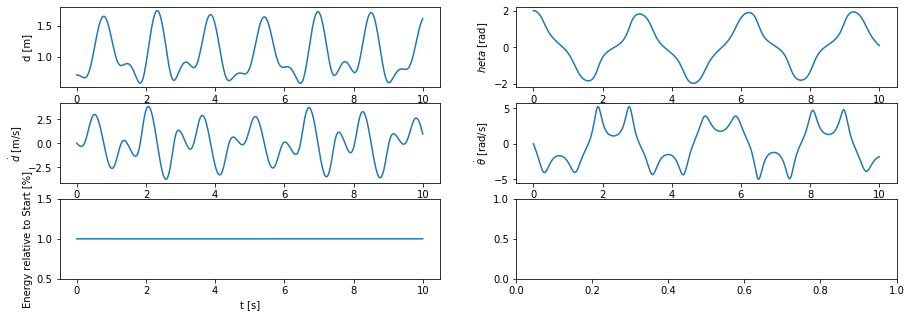

In [4]:
tmax, dt = 10, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

params = p.GetNumericTuple()
y0 = [2,0,-0.3,0]
yData = solve_ivp(lambda t,y:sm.deriv(t,y,p),(0,tmax),y0,max_step=dt)

yData.y[0][0]



# interpolate data onto a uniform time grid
t = np.arange(0, tmax+dt, 0.01)
yi = np.zeros((len(t),len(y0))).T
for i in range(0,len(y0)):
    yi[i] = np.interp(t,yData.t,yData.y[i])
    
    

fig, axes = plt.subplots(3,2,figsize=(15,5))

# d plot
axes[0][0].plot(t,yi[2]+p.l.value)
axes[0][0].set_ylabel('d [m]')
axes[0][0].set_xlabel('t [s]')

# theta plot
axes[0][1].plot(t,yi[0])
axes[0][1].set_ylabel('$\theta$ [rad]')
axes[0][1].set_xlabel('t [s]')


# ddot plot
axes[1][0].plot(t,yi[3])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[1])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

# energy
axes[2][0].plot(t,sm.Energy(yi,p)/sm.Energy(yi[:,0],p))
axes[2][0].set_ylabel(r'Energy relative to Start [%]')
axes[2][0].set_xlabel('t [s]')
axes[2][0].set_ylim(0.5,1.5)



In [5]:
import matplotlib.animation as animation
from IPython.display import HTML

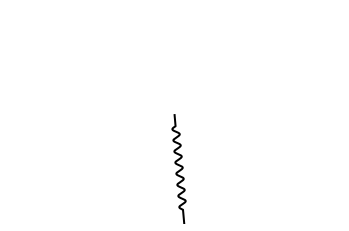

In [73]:
fig = plt.figure()
ax = plt.axes(xlim=(-2,2),ylim=(-4,4))
ax.axis('equal')
ax.set()
spring = cpo.Spring.FromLengthAndAngle(np.pi/2,p.l.value,ax = ax)

# initialization function 
def init(): 
    # creating an empty plot/frame 
    spring.ReplotSpring((0,0),y0[0],p.l.value+y0[2])              
    return spring.springObj,
                    
def animate(i):
    theta = yi[0,i]
    d = yi[2,i]
    spring.ReplotSpring((0,0),theta,d+p.l.value)   
    return spring.springObj,

plt.axis('off')    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=25, blit=True)
HTML(anim.to_html5_video())
